In [1]:
# importing libraries and dependencies:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt
import keras as k
from keras.optimizers import RMSprop, Nadam
from keras.losses import Huber


import warnings
warnings.filterwarnings("ignore")

C:\Users\zm_if\AppData\Local\Temp\ipykernel_10792\35441435.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# importing the dataset:
data = pd.read_fwf("auto+mpg/auto-mpg.data", header= None)
# column names:
columns = ["mpg","cylinders","displacement","horsepower","weight",
    "acceleration","model_year","origin","car_name"
    ]
# setting the appropriate column names:
data.columns = columns

a. Drop the name and origin attributes:

In [3]:
# dropping the 2 unwanted columns:
data = data.drop(columns=["origin", "car_name"])

In [4]:
# sanity check:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70


##### EDA
b. Attribute horsepower has 6 missing values. Fill these up with the average
horsepower for the respective number of cylinders

In [5]:
# checking the obvious nulls and data types:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 21.9+ KB


In [6]:
# coverting the data type to numeric:
data.horsepower = pd.to_numeric(data.horsepower, errors="coerce")

In [7]:
# sanity check:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
dtype: object

In [8]:
# checking fo the nulls:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
dtype: int64

In [9]:
# Visualizing the rows missing data:
data[data.horsepower.isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
32,25.0,4,98.0,NaN,2046.0,19.0,71
126,21.0,6,200.0,NaN,2875.0,17.0,74
330,40.9,4,85.0,NaN,1835.0,17.3,80
336,23.6,4,140.0,NaN,2905.0,14.3,80
354,34.5,4,100.0,NaN,2320.0,15.8,81
374,23.0,4,151.0,NaN,3035.0,20.5,82


In [10]:
# Using the average hp relative to the cylinders:
cyl4_horsepower = data[data.cylinders == 4]["horsepower"].mean(skipna=True).round(2)
cyl6_horsepower = data[data.cylinders == 6]["horsepower"].mean(skipna=True).round(2)

In [11]:
# imputing the missing data with the relative mean:
data.loc[(data.horsepower.isna()) & (data.cylinders == 4), "horsepower"] = cyl4_horsepower
data.loc[(data.horsepower.isna()) & (data.cylinders == 6), "horsepower"] = cyl6_horsepower

c. The year attribute has two digits. Add 1900 so that the year has four digits. For
example, in the dataset “70” really means “1970”, so you need to change the value from 70 to
1970.

In [12]:
# Fixing the year feature:
data["model_year"]  = data.model_year + 1900

In [13]:
# sanity check:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
0,18.0,8,307.0,130.0,3504.0,12.0,1970
1,15.0,8,350.0,165.0,3693.0,11.5,1970
2,18.0,8,318.0,150.0,3436.0,11.0,1970
3,16.0,8,304.0,150.0,3433.0,12.0,1970
4,17.0,8,302.0,140.0,3449.0,10.5,1970


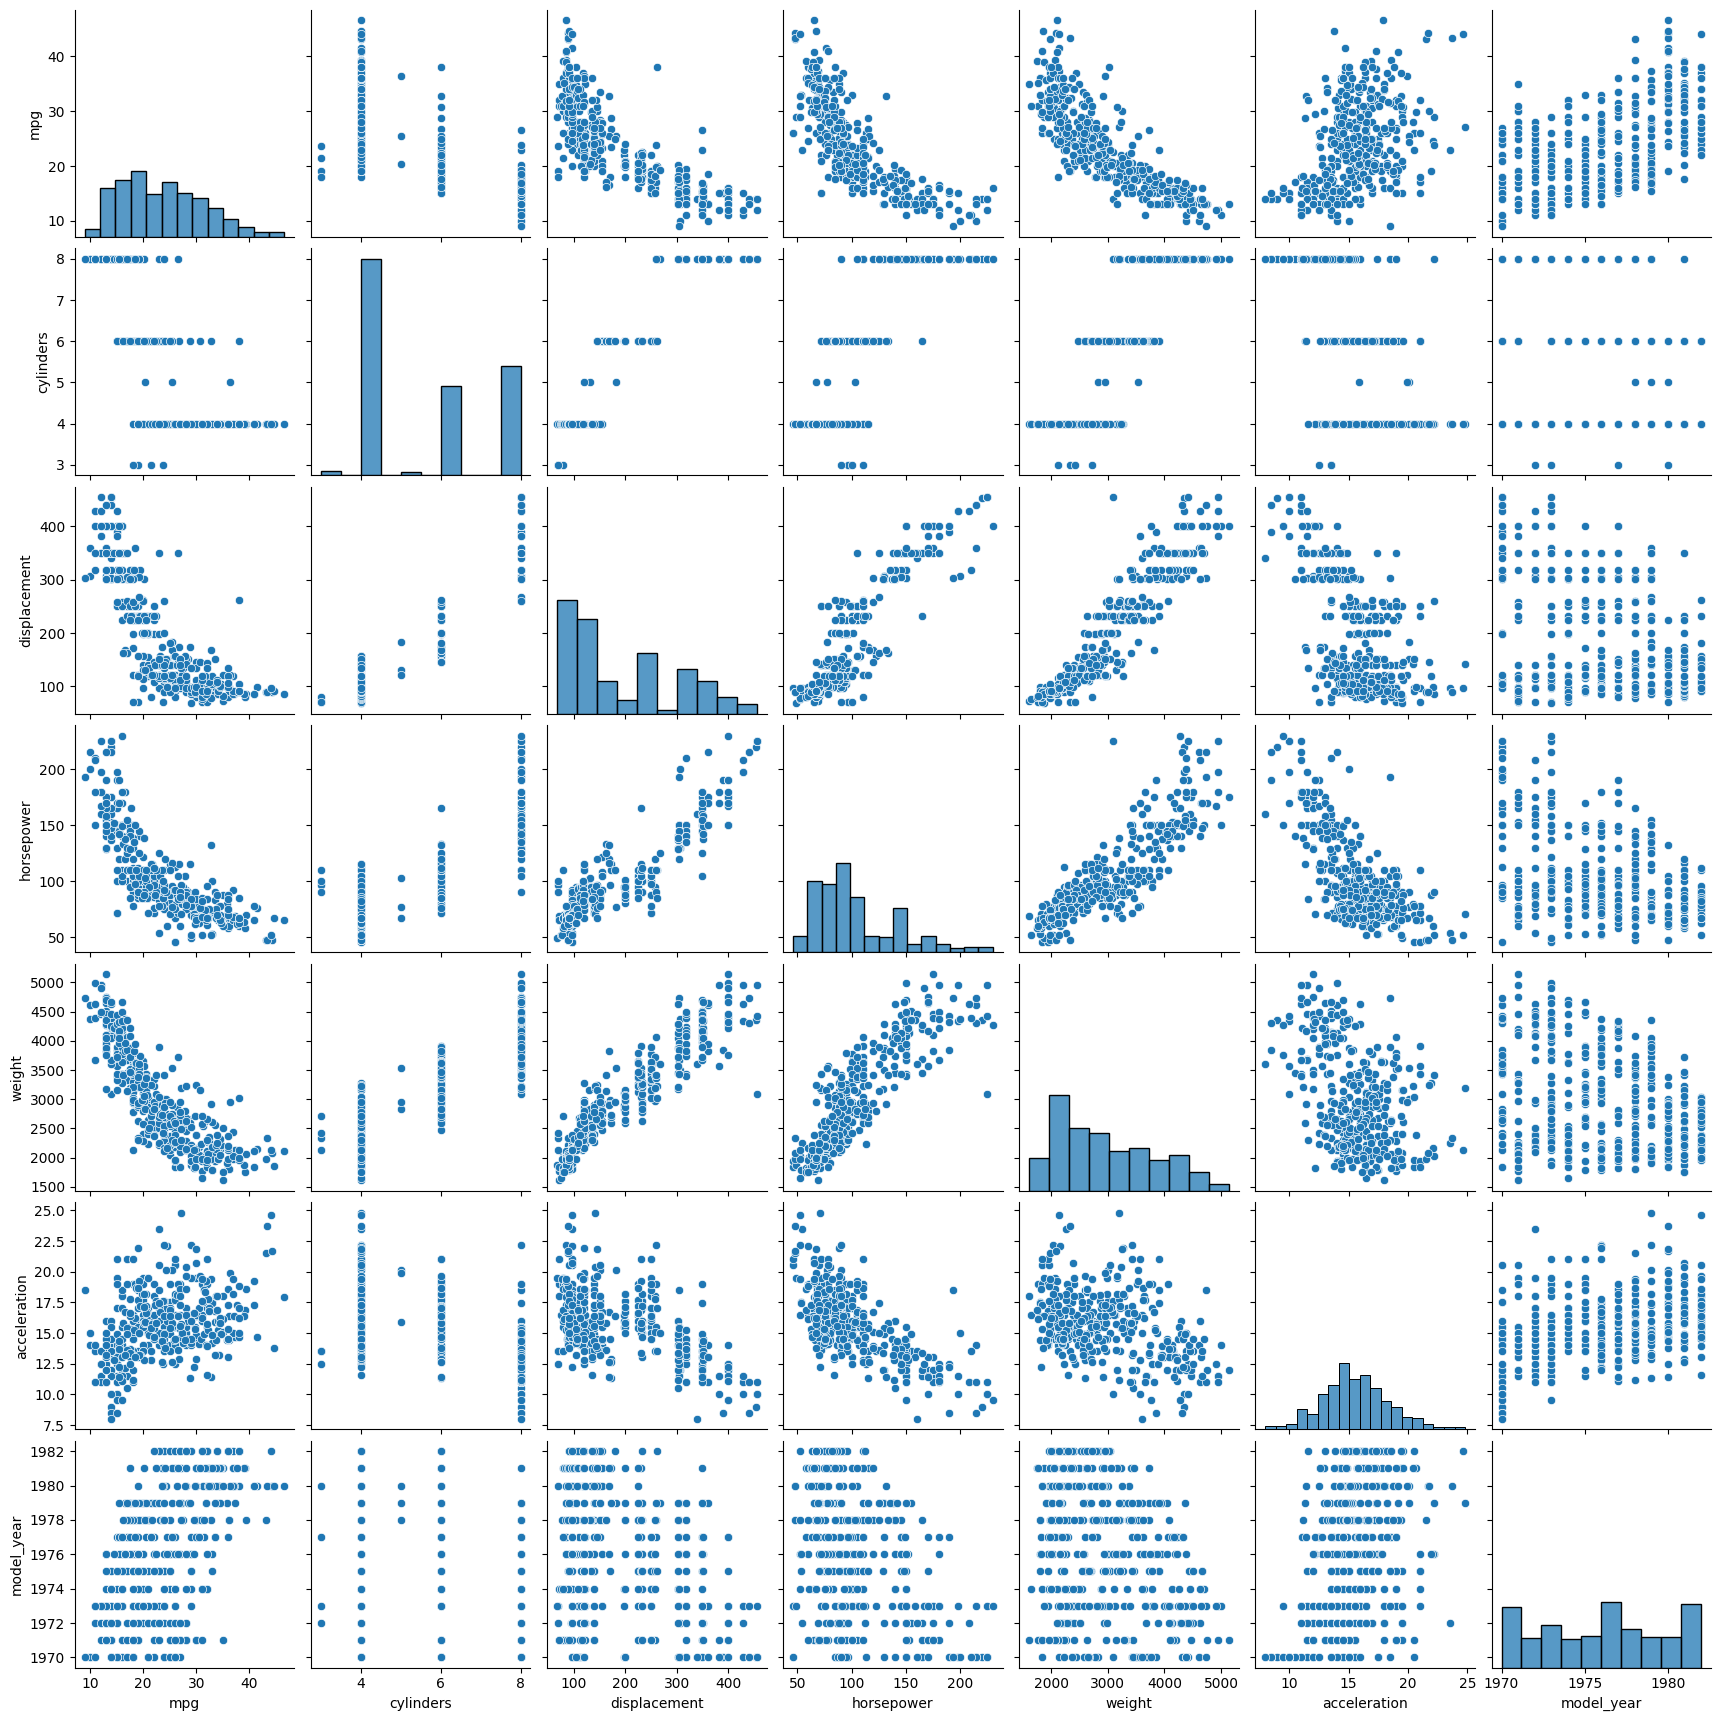

In [14]:
# getting a general sense of data:
sns.pairplot(data) 
plt.plot();

In [15]:
# Some findings from the plot:
# 1. cylinder data has unbalanced representation
# 2. mpg inversely proportional to displacement, horsepower and weight
# 3. mpg directly proportional to acceleration

# interesting finding:
# 1. hp is negative correlation with acceleration

[]

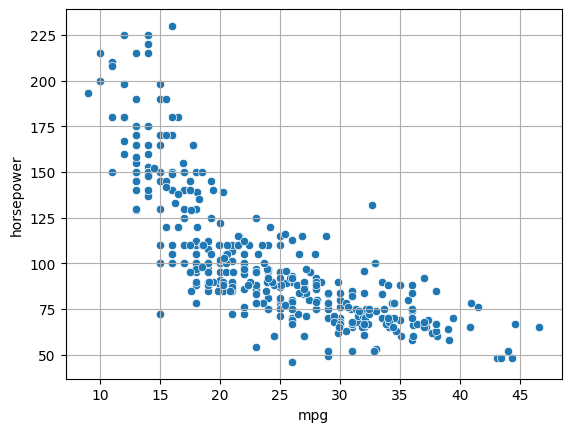

In [16]:
sns.scatterplot(x=data.mpg, y=data.horsepower)
plt.grid()
plt.plot()

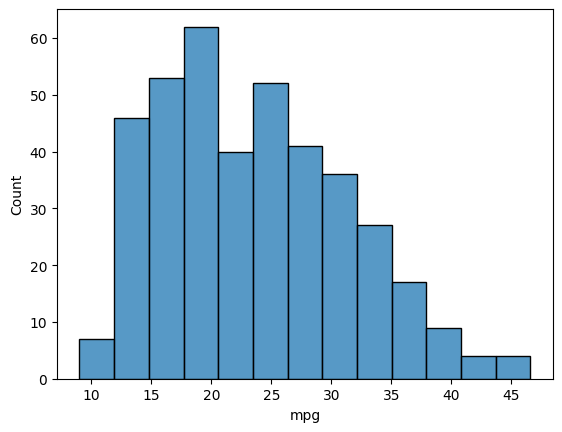

In [17]:
sns.histplot(data.mpg)
plt.plot();

In [18]:
# Seperating the features from the target 
X = data.drop(columns = "mpg")
y = data["mpg"]

In [19]:
# Scaling the data:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

d. Split the data into 50% training and 50% validation sets

In [20]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size=0.5, random_state=2)

e. Train a keras.models.Sequential DNN that predicts the mpg of vehicles

In [21]:
# training a sequential model:
model = k.models.Sequential()
model.add(k.layers.Dense(6, activation="relu", input_shape=(6,)))

model.add(k.layers.Dense(12, activation="relu"))
model.add(k.layers.Dense(24, activation="relu"))
model.add(k.layers.Dense(12, activation="relu"))

model.add(k.layers.Dense(1, activation="linear"))

model.compile(optimizer=RMSprop(), loss = Huber(), metrics = ["mae"])

In [22]:
# Ttraining the model:
history  = model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=200)

Epoch 1/200


7/7 [==============================] - 1s 28ms/step - loss: 23.2002 - mae: 23.7002 - val_loss: 22.8499 - val_mae: 23.3499
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 23.0639 - mae: 23.5639 - val_loss: 22.7673 - val_mae: 23.2673
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 22.9901 - mae: 23.4901 - val_loss: 22.6958 - val_mae: 23.1958
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 22.9159 - mae: 23.4159 - val_loss: 22.6149 - val_mae: 23.1149
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 22.8274 - mae: 23.3274 - val_loss: 22.5118 - val_mae: 23.0118
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 22.7132 - mae: 23.2132 - val_loss: 22.3795 - val_mae: 22.8795
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 22.5711 - mae: 23.0711 - val_loss: 22.2171 - val_mae: 22.7171
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - l

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["mae"]
val_acc = history.history["val_mae"]

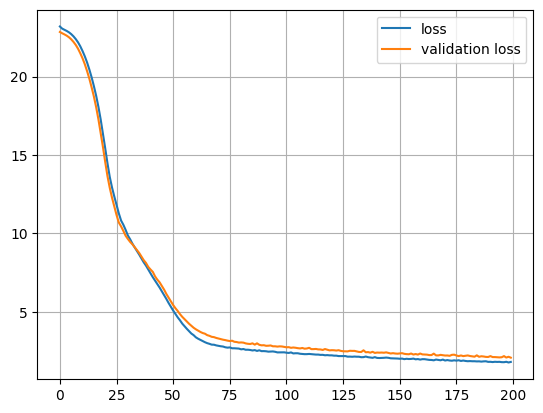

In [24]:
plt.plot(loss, label="loss")
plt.plot(val_loss, label = "validation loss")
plt.legend()
plt.grid()
plt.show();

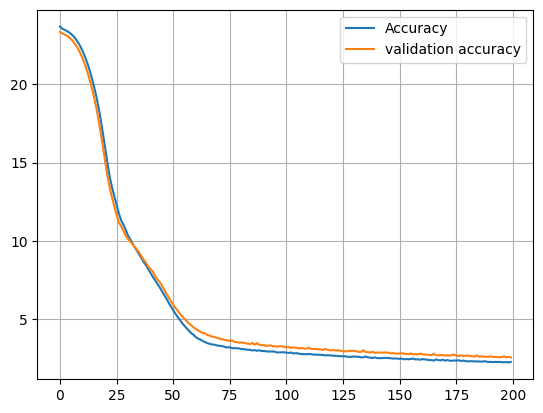

In [25]:
plt.plot(acc, label="Accuracy")
plt.plot(val_acc, label = "validation accuracy")
plt.legend()
plt.grid()
plt.show();

In [26]:

# unseen_data = [
#     {"vehicle": 1, "Cylinders": 6, "displacement": 2170, "horsepower": 502, "Weight": 3164, "acceleration": 4.2, "year": 2023},
#     {"vehicle": 2, "Cylinders": 12, "displacement": 6498, "horsepower": 730, "Weight": 3472, "acceleration": 3.2, "year": 2023},
#     {"vehicle": 3, "Cylinders": 8, "displacement": 3902, "horsepower": 986, "Weight": 3020, "acceleration": 2.5, "year": 2023},
#     {"vehicle": 4, "Cylinders": 8, "displacement": 6162, "horsepower": 670, "Weight": 3721, "acceleration": 2.6, "year": 2023},
#     {"vehicle": 5, "Cylinders": 4, "displacement": 122, "horsepower": 181, "Weight": 2496, "acceleration": 8.3, "year": 2023},
#     {"vehicle": 6, "Cylinders": 6, "displacement": 3232, "horsepower": 155, "Weight": 3232, "acceleration": 11.5, "year": 1969},
#     {"vehicle": 7, "Cylinders": 3, "displacement": 598, "horsepower": 89, "Weight": 1550, "acceleration": 10.1, "year": 2023},
#     {"vehicle": 8, "Cylinders": 3, "displacement": 900, "horsepower": 50, "Weight": 642, "acceleration": 5.8, "year": 2023},
#     {"vehicle": 9, "Cylinders": 4, "displacement": 1189, "horsepower": 60, "Weight": 2355, "acceleration": 28.1, "year": 1964},
#     {"vehicle": 10, "Cylinders": 4, "displacement": 201, "horsepower": 40, "Weight": 2265, "acceleration": 32, "year": 1908},
# ]

unseen_data = [
    {"vehicle": 1, "Cylinders": 6, "displacement": 2170, "horsepower": 502, "Weight": 3164, "acceleration": 4.2, "year": 1975},
    {"vehicle": 2, "Cylinders": 12, "displacement": 6498, "horsepower": 730, "Weight": 3472, "acceleration": 3.2, "year": 1975},
    {"vehicle": 3, "Cylinders": 8, "displacement": 3902, "horsepower": 986, "Weight": 3020, "acceleration": 2.5, "year": 1975},
    {"vehicle": 4, "Cylinders": 8, "displacement": 6162, "horsepower": 670, "Weight": 3721, "acceleration": 2.6, "year": 1975},
    {"vehicle": 5, "Cylinders": 4, "displacement": 122, "horsepower": 181, "Weight": 2496, "acceleration": 8.3, "year": 1975},
    {"vehicle": 6, "Cylinders": 6, "displacement": 3232, "horsepower": 155, "Weight": 3232, "acceleration": 11.5, "year": 1975},
    {"vehicle": 7, "Cylinders": 3, "displacement": 598, "horsepower": 89, "Weight": 1550, "acceleration": 10.1, "year": 1975},
    {"vehicle": 8, "Cylinders": 3, "displacement": 900, "horsepower": 50, "Weight": 642, "acceleration": 5.8, "year": 1975},
    {"vehicle": 9, "Cylinders": 4, "displacement": 1189, "horsepower": 60, "Weight": 2355, "acceleration": 28.1, "year": 1975},
    {"vehicle": 10, "Cylinders": 4, "displacement": 201, "horsepower": 40, "Weight": 2265, "acceleration": 32, "year": 1975},
]

df = pd.DataFrame(unseen_data)


In [33]:
data.describe().round(1)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.0,398.0,398.0,398.0,398.0,398.0,398.0
mean,23.5,5.5,193.4,104.1,2970.4,15.6,1976.0
std,7.8,1.7,104.3,38.3,846.8,2.8,3.7
min,9.0,3.0,68.0,46.0,1613.0,8.0,1970.0
25%,17.5,4.0,104.2,76.0,2223.8,13.8,1973.0
50%,23.0,4.0,148.5,92.0,2803.5,15.5,1976.0
75%,29.0,8.0,262.0,125.0,3608.0,17.2,1979.0
max,46.6,8.0,455.0,230.0,5140.0,24.8,1982.0


In [27]:
df = df.drop(columns = "vehicle")
df

,Cylinders,displacement,horsepower,Weight,acceleration,year
0,6,2170,502,3164,4.2,1975
1,12,6498,730,3472,3.2,1975
2,8,3902,986,3020,2.5,1975
3,8,6162,670,3721,2.6,1975
4,4,122,181,2496,8.3,1975
5,6,3232,155,3232,11.5,1975
6,3,598,89,1550,10.1,1975
7,3,900,50,642,5.8,1975
8,4,1189,60,2355,28.1,1975
9,4,201,40,2265,32.0,1975


In [28]:
infer_data = df.values
infer_scaled = scaler.transform(infer_data)

In [29]:
pred = model.predict(infer_data)

1/1 [==============================] - 0s 87ms/step


In [30]:
pred

array([[15597.63 ],
       [24060.008],
       [19012.518],
       [23883.639],
       [11984.477],
       [18810.926],
       [13461.785],
       [18018.03 ],
       [14347.409],
       [12202.26 ]], dtype=float32)